# <center>Special lecture 1: min-cost flow problems -- Creating a GPS</center>
### <center>Alfred Galichon (NYU & Sciences Po) and Clément Montes (Sciences Po)</center>
## <center>'math+econ+code' masterclass on optimal transport and economic applications</center>
#### <center>With python code examples</center>
© 2018-2022 by Alfred Galichon. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/team).

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass on optimal transport and economic applications, January 2022. https://github.com/math-econ-code/mec_optim

### Learning Objectives 

* Basic concepts of directed networks

* The min-cost flow problem

* Duality, optimality and equilibrium

### References

* Galichon, *Optimal Transport Methods in Economics*. Ch.8.

* Tolstoi (1930). Methods of finding the minimal total kilometrage in cargo transportation planning in space. *Transportation Planning* [in Russian]

* Koopmans (1949). Optimum utilization of the transportation system. *Econometrica*.

* Schrijver (2002). On the History of the Transportation and Maximum Flow Problems. *Mathematical programming*.

## Motivation

### Motivation: network flow problems

In 1930 Tolstoi, a Russian engineer, has to optimize the shipping of cement from factories to cities in the Soviet union through railway.

* each factory produces a fixed number of tons

* each city needs a fixed number of tons -- for now, we'll assume total production=total consumption

* each factory is connected by rail with a few cities, and the corresponding distance is given

* how to ship in order to minimize the total distance travelled?

This problem belongs to the class of *min-cost flow problems*, an important class of linear programming problems, which are the focus of today's lecture. A decade before the invention of linear programming and the work of Kantorovich, Koopmans and Dantzig, Tolstoi described a heuristic method for solving the problem, which led to the optimal solution. As one can recover using modern tools, and will see that his solution was right.

The *shortest path problem*, or how to find the path of minimal distance from a point to another in a network, also belongs in this class. 

Fist, let's load libraries we'll need. We'll need `os` and `pandas` for data importation and manipulations, `numpy` and part of `scipy` for computations, `gurobipy` for linear programming using Gurobi, `osmnx` to import map data from [OpenStreetMap](https://www.openstreetmap.org/), `networkx` for operations on networks, parts of `matplotlib` for displays,  


In [1]:
import numpy as np
import scipy.sparse as sp
import osmnx as ox
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# !python -m pip install -i https://pypi.gurobi.com gurobipy ## only if Gurobi not here
import gurobipy as grb


# A look at our data


We will create a class `network_problem` to collect and store the relevant information we need: nodes, arcs, and arc lengths. We will add methods later.

In [2]:
class network_problem:
    def __init__(self,nodesList,arcsList,costsList):
        self.nbNodes = len(nodesList)
        self.nbArcs = len(arcsList)
        self.nodesList = nodesList
        self.arcsList = arcsList
        self.costsList = costsList
        self.nodesDict = {node:node_ind for (node,node_ind) in zip(self.nodesList,range(self.nbNodes))}
        self.arcsDict = {arc:arc_ind for (arc,arc_ind) in zip(self.arcsList,range(self.nbArcs))}
        print('Number of nodes='+str(self.nbNodes)+'; number of arcs='+str(self.nbArcs)+'.')

## Paris streets

Next, we gather data on the network of the Paris streets. To do this, we use the `osmnx` package to retrieve data from [OpenStreetMap](https://www.openstreetmap.org/). Doing this is as simple as specifying an address, and calling the `graph_from_address` function, specifying the desired distance (in meters) around this address. 

In this specific case: we construct and represent the pedestrian graph, 2 kilometers around the address of NYU in Paris.

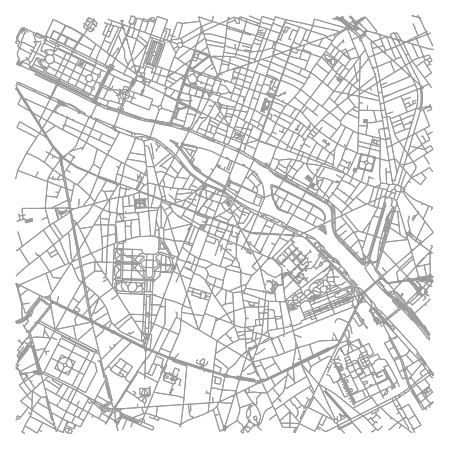

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
nyu_address='57 boulevard Saint-Germain, 75005 Paris, France'
streets_network = ox.graph.graph_from_address(nyu_address, dist=2000,network_type = 'walk')
ox.plot_graph(streets_network,node_size=0, bgcolor='w')

As we see, the essential information we can extract from the graph is the list of nodes (`list(streets_network.nodes)` below), the list of arcs (`arcslist` below) and their associated costs (`costlist` below).

In [4]:
arcslist = [(i,j) for (i,j,k) in list(streets_network.edges)]
costslist = [streets_network[i][j][0]["length"] for i,j in arcslist ]
streets_pb = network_problem(list(streets_network.nodes),arcslist,costslist) 

Number of nodes=7679; number of arcs=21314.


Now that we have the structure of the data in mind, let's develop the conceptual tools we shall need in our analysis.

## Topology of networks

### Directed graph

We start by defining the directed graph on which transportation takes place.

---
**Definition**

A (directed) *graph* $\left(\mathcal{Z},\mathcal{A}\right)$ is a set of *nodes* (cities) $\mathcal{Z}$, along with a set of *arcs* $\mathcal{A}\subseteq\mathcal{Z}^{2}$ which are pairs $\left(x,y\right)$ where $x\neq y\in\mathcal{Z}$.

---
Our definition does not allow for an arc to have the same origin and destination. Note that for a dense network, $\left\vert \mathcal{A} \right\vert = \left\vert \mathcal{Z}\right\vert\left( \left\vert \mathcal{Z}\right\vert - 1 \right)$. For a line, $\left\vert \mathcal{A}\right\vert =\left\vert \mathcal{Z}\right\vert -1$.

**Stylized example**. Take the following example, which we shall use for exposition purposes:

Number of nodes=4; number of arcs=5.


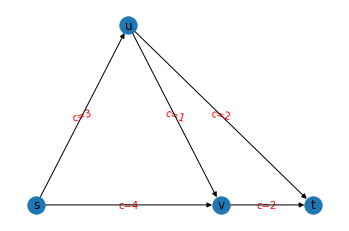

In [5]:
example_graph = nx.DiGraph()
arcslist = [('s','u'),('u','v'),('s','v'),('u','t'),('v','t')]
costslist = [3,1,4,2,2]
example_graph.add_edges_from(arcslist)

example_pb = network_problem(list(example_graph.nodes),arcslist,costslist) 

pos = {'s':np.array([0,0]),'u':np.array([1,0.5]),'v':np.array([2,0]),'t':np.array([3,0])} 
nx.draw_networkx_edge_labels(example_graph,pos,edge_labels={e:('c='+str(l)) for (e,l) in zip(arcslist,costslist)},font_color='red')
nx.draw(example_graph,pos,with_labels=True)
plt.show()

### Gradient matrix

Next, we define the gradient matrix, which encodes the information contained in the directed graph.

---
**Definition**
<a name="grad_mat"></a>

We define the *gradient matrix* (also called an `edge-node matrix') as the matrix with general term $\nabla_{ax}$, $a\in\mathcal{A}$, $x\in \mathcal{Z}$, such that

\begin{align*}
\nabla_{ax}  &  =-1\text{ if }a\text{ is out of }x\text{,}\\
&  =+1\text{ if }a\text{ is into }x\text{,}\\
&  =0\text{ else.}
\end{align*}

---

Hence, if $f\in\mathbb{R}^{\mathcal{Z}}$, then $\nabla f\in\mathbb{R}^{\mathcal{Z}}$, and $\left(  \nabla f\right)  _{xy}=f_{y}-f_{x}$.

We shall denote $\nabla^{\intercal}$ the transpose of the gradient matrix. It is the network analog of the $-\operatorname{div}$ differential operator.


From the list of arcs, now we can easily construct our $\nabla$ matrix, as the first component of each element of `arcs` is the origin node (which will have $-1$ entry in $\nabla$) and the second component is the destination nodes (which will have $+1$ entry). 
An important feature of the matrix $\nabla$ is *sparsity*: for each row (arcs), there are only two nonzero terms. We should recognize this sparse structure and code $\nabla$ as a sparse matrix. In `scipy`, this is done using `csr_matrix`. 
We implement this as follows:

In [6]:
def Nabla(self):
    data = np.concatenate([-np.ones(self.nbArcs),np.ones(self.nbArcs)])
    arcsIndices = list(range(self.nbArcs))
    arcsOrigins = [self.nodesDict[o] for o,d in self.arcsList]
    arcsDestinations = [self.nodesDict[d] for o,d in self.arcsList]
    theNabla = sp.csr_matrix((data, (arcsIndices+arcsIndices, arcsOrigins+arcsDestinations)), shape = (self.nbArcs,self.nbNodes))
    return(theNabla)

network_problem.Nabla = Nabla

If we want to visualize, we need to convert it to a `np.array` matrix using the `.toarray()` method. 

**Stylized example**. In the case of our example, the matrix looks like the following:

In [7]:
example_pb.Nabla().toarray()

array([[-1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  0.],
       [-1.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  1.],
       [ 0.,  0., -1.,  1.]])

Take the first line in the example above, for instance, which is associated with the `uv` arc. It has a $-1$ entry on the first column entry (indicating leaving the node `u`), and a $+1$ entry on the second column entry (indicating entering the node `v`).

### Paths and loops

Next, we define the terms *paths* and *loops*.

---
**Definition**

Given two nodes $x$ and $y$, a *path* from $x$ to $y$ is a sequence $z_{1},z_{2},...,z_{K}$ in $\mathcal{Z}$ where $z_{1}=x$, $z_{K}=y$, and for every $1\leq k\leq K-1$, $\left(  z_{k},z_{k+1}\right)  \in\mathcal{A}$.


A *loop* (also called `cycle') is a path from a node $x$ to itself.

---

**Stylized example**. In our stylized example, `(s,u,v,t)` is a path, but `(s,v,u,t)` is not a path.

### Transportation costs

A vector $c\in\mathbb{R}^{\mathcal{A}}$ defines transportation costs. That is, for $xy\in\mathcal{A}$, $c_{xy}$ is the transportation cost associated to arc $xy$. $c$ can also be thought of as the length of arc $xy$. The cost of moving the good from node $x$ to node $y$ along path $z_{1},z_{2},...,z_{K}$ is

\begin{align*}
\sum_{k=1}^{K-1}c_{z_{k}z_{k+1}}.
\end{align*}

## Assumptions about the network

We shall introduce a number of natural assumptions about the network.

### No profitable loop
---
**Assumption** [No profitable loop]
<a name="noprofitloop"></a>

There is no profitable loop, which means that there is no sequence $z_{1},...,z_{K}$ in $\mathcal{Z}$ such that $z_{K}=z_{1}$, $\left(  z_{k},z_{k+1}\right)  \in\mathcal{A}$, and $\sum_{k=1}^{K-1}c_{z_{k}z_{k+1}}<0$.

---

In particular, there is no profitable loop if $c\geq0$.

### Balancedness
Let $q_{z}$ be the *net demand* at node $z \in \mathcal{Z}$, which is the quantity of goods disappearing from the graph. The set of nodes defined by

\begin{align*}
\mathcal{Z}_{0}=\left\{  x\in\mathcal{Z}:q_{x}<0\right\}  \text{, and }\mathcal{Z}_{1}=\left\{  y\in\mathcal{Z}:q_{y}>0\right\}
\end{align*}

are called the *supply nodes* and *demand nodes* respectively. A node which is neither a supply node, neither a demand node is called a *transit node*.

Total supply is $-\sum_{x\in\mathcal{Z}_{0}}q_{x}$, total demand is $\sum_{y\in\mathcal{Z}_{1}}q_{y}$.

---
**Assumption** [Balancedness] 
<a name="balancedness"></a>

Assume that total supply equals total demand on the network, that is

\begin{align*}
\sum_{x\in\mathcal{Z}_{0}}q_{x}+\sum_{y\in\mathcal{Z}_{1}}q_{y}=0.
\end{align*}

---

### Connectedness

---
**Assumption** [Connectedness]
<a name="connectedness"></a>

Assume the set of supply nodes $\mathcal{Z}_{0}$ is *strongly connected* to the set of demand nodes $\mathcal{Z}_{1}$, i.e. for every $x\in\mathcal{Z}_{0}$ and $y\in \mathcal{Z}_{1}$, there is a path from $x$ to $y$.

---


### Regular networks

The specification of the graph, the net demand vector, and the surplus vector
defines a network.

---
**Definition**

A directed graph $\left(\mathcal{Z},\mathcal{A}\right)$ endowed with a net demand vector $\left(n_{z}\right)_{z \in \mathcal{Z}}$ and a cost vector $\left(c_{a}\right)_{a\in\mathcal{A}}$ is called a *network* $\left(\mathcal{Z}, \mathcal{A}, q, c\right)$. If the three assumptions above: [no profitable loop](#noprofitloop), [balancedness](#balancedness) and [connectedness](#connectedness) all hold, the network is called *regular*.

---

Without mention of the contrary we shall assume that the network under consideration is regular.


### Flows and feasible flows

A *flow* is a vector $\mu$ on $\mathbb{R}_+^{\mathcal{A}}$, where $\mu_a$ is the quantity of mass passing through arc $a$.

The flow of mass disappearing at $z$ equals the flow arriving from other nodes minus the flow shipping to other nodes

\begin{align*}
q_{z}=\sum_{x:xz \in\mathcal{A}}\mu_{xz}-\sum_{y:zy \in\mathcal{A}}\mu_{zy}
\end{align*}

and this equation can be rewritten as $\nabla^{\intercal}\mu=n$. This motivates the following definition:

---
**Definition**

The set of feasible flows associated with $q$, denoted $\mathcal{M}\left(  q\right)$, or $\mathcal{M}$ when there is no ambiguity, is defined as the set of flows $\mu\geq0$ that verify conservation equation

\begin{align*}
    \nabla^{\intercal}\mu=q.
\end{align*}

---


**Stylized example**. In our stylized example, the flow of mass $\mu$ associated with arc `(s,u,v,t)` has one unit of mass on arcs `su`,`uv`, and `vt`. Hence,  $\nabla ^\top \mu$ is: 

In [8]:
# example_pb.arcsList
# example_pb.nodesList
mu = np.array([1,1,0,0,1])
(example_pb.Nabla().transpose() * mu.reshape(-1,1)).reshape(1,-1)

array([[-1.,  0.,  0.,  1.]])

We see that the vector of exiting flows $\nabla ^\top \mu$ is equal to $-1$ on arc `s`, equal to $1$ on arc `t`, and equal to zero elsewhere. Mass ''appears'' at the start of the path `s`, ''disappears'' at the end of the path `t`, and is conserved along the path and elsewhere in the network.  

Conversely, if $q_z = 1\{z=t\} - 1\{z=s\}$, and for $\mu\in\mathcal{M}(q)$, one may find a path from `s` to `t` along the support of $\mu$, by the following simple algorithm, which consists of looking for an arc in the support of $\mu$ originating at the current node, replacing the current node by the destination of the arc, and deleting the arc. It is easy to see that this algorithm will get from `s` to `t` in a finite number of steps. We implement it below: 

In [9]:
def pathfinder(self,mu,sind,tind):
    # assume mu is such that $\Nabla^\top \mu =1 on t, =-1 on s, and =0 elsewhere
    t = self.nodesList[tind]
    arcs_active = [(x,y) for (x,y) in self.arcsList if (mu[self.arcsDict[(x,y)]] > 0) ]
    current = self.nodesList[sind]
    path = [current]
    while current != t:
        (x,y) = next((x,y) for (x,y) in arcs_active if x==current)
        path.append(y)
        current = y
        arcs_active.remove((x,y))
    return(path)
    

network_problem.pathfinder = pathfinder

**Stylized example**. We run this in our stylized example, to determine a path associated with `mu = np.array([1,1,0,0,1])` from `s`to `t`. We get:

In [10]:
example_pb.pathfinder(mu,0,3)

['s', 'u', 'v', 't']

## The min-cost flow problem

Let $p_{z}$ be the price of the commodity at $z$. Consider the strategy which consists in purchasing the good at $x$, shipping to $y$, and selling at $y$. The profit of this strategy is

\begin{align*}
p_{y}-p_{x}-c_{xy}=\left(  \nabla p-c\right)_{xy}
\end{align*}

and hence there is no arbitrage opportunity if $p_{y}-p_{x}-c_{xy}\leq0$ for every arc $xy$, that is

\begin{align*}
\nabla p\leq c.
\end{align*}

Consider the *minimum cost flow problem*
<a name="primal"></a>
\begin{align*}
&  \min_{\mu\geq0}\sum_{\left(  x,y\right)  \in\mathcal{A}}\mu_{xy}%
c_{xy} \\
&  s.t.~\nabla^{\intercal}\mu=q
\end{align*}

which is a linear programming problem whose dual is
<a name="dual"></a>
\begin{align*}
&  \max_{p\in\mathbb{R}^{\mathcal{Z}}}\sum_{z\in\mathcal{Z}}p
_{z} q_{z}\\
&  s.t.~\nabla p\leq c.
\end{align*}


## Min-cost flow duality

---
**Proposition**
1. Under Assumption [No profitable loop](#noprofitloop), the [dual problem](#dual) is feasible, which means that there is a vector $p\in\mathbb{R}^{\mathcal{Z}}$ such that $\nabla p\leq c$; and the value of [primal problem](#primal) is strictly less than $+\infty$.

2. Under Assumptions [balancedness](#balandedness) and [connectedness](#connectedness), the [primal problem](#primal) is feasible, which means that there is a flow $\mu\geq0$ such that $\nabla^{\intercal}\mu=q$; and the value of [dual problem](#dual) is strictly greater than $-\infty$.

---

Assume that $\left(\mathcal{Z},\mathcal{A},q,c\right)$ is a regular network. Then the value of the [primal problem](#primal) coincides with the value of its [dual](#dual), and both problems have solutions. Further, if $\mu$ is a solution to the primal and $p$ is a solution to the dual, then $\mu_{xy}>0$ implies $p_{y}-p_{x}=c_{xy}$.

In [11]:
def network_problem_mincostflow(self,q,OutputFlag=True):
    Nabla = self.Nabla()
    m=grb.Model()
    m.setParam('OutputFlag', OutputFlag)
    p = m.addMVar(shape=self.nbNodes, name="p", lb = float('-inf'))
    m.setObjective(q @ p, grb.GRB.MAXIMIZE)
    m.addConstr( Nabla @ p <= np.array(self.costsList))
    m.optimize()
    if m.status == grb.GRB.Status.OPTIMAL:
        p_z = m.getAttr('x')
        mu_a = m.getAttr('pi')
    return np.array((p_z,mu_a),dtype=object)

network_problem.mincostflow =  network_problem_mincostflow

# Special cases

## Shortest path problem

Assume there is only one source node $s \in \mathcal{Z}$ and one target node $t\in\mathcal{Z}$, each associated with unit flow. That is, $q_{z}=1\left\{  z=t\right\}  -1\left\{  z=s\right\}$. Then the problem boils down to how to push one unit of mass from $s$ to $t$. If we interpret $c_{xy}$ as the distance along arc $xy$, the solution of this problem corresponds to the shortest path from $s$ to $t$. This is why this problem is called shortest path problem. (More generally, this problem extends to the case when $c$ does not have a negative loop).

The dual problem is then

\begin{align*}
\max_{p}  &  ~p_{t}-p_{s}\\
s.t.  &  ~p_{y}-p_{x}\leq c_{xy}~\forall xy\in\mathcal{A}
\end{align*}

and we can impose normalization $p_{s}=0$, so that along the travelled path, $p_{z}$ interprets as the distance travelled thus far.

**Stylized example**. We run the min-cost flow problem in its ''shortest path'' version on our stylized example, with origin at node `s` and destination at node `t`.

In [12]:
p_z,mu_a = example_pb.mincostflow(np.array([[-1.,  0.,  0.,  1.]]))
print('\np_z='+str(p_z)+', and \nμ_a ='+str(mu_a) )
#example_pb.arcsList
example_pb.pathfinder(mu_a,0,3)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Academic license - for non-commercial use only - registered to clement.montes@sciencespo.fr
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to clement.montes@sciencespo.fr
Optimize a model with 5 rows, 4 columns and 10 nonzeros
Model fingerprint: 0xd068e937
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 4 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+00   0.000000e+00   2.000000e-06      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective  5.000000000e+00

p_z=[-3.0, 0.0, 0.0, 2.0], and 
μ_a =[1.0,

['s', 'u', 't']

We see that the shortest path in the stylized example is `sut`, with a total cost of 5.

In [13]:
def network_problem_shortestPathLP(self,origin_node,destination_node, OutputFlag = True):
    q = np.zeros(self.nbNodes)
    q[origin_node] = -1
    q[destination_node] = 1
    p_z,mu_a = self.mincostflow(q,OutputFlag)
    return self.pathfinder(mu_a,origin_node,destination_node)

network_problem.shortestPathLP = network_problem_shortestPathLP

**Paris streets dataset**. We shall now look for the shortest path between the centers of NYU and Columbia in Paris through the pedestrian network on the Parisian streets. First, let us use `osmnx`'s function `geocode` to convert the addresses into geographic coordinates, and then `get_nearest_node` to find the two nearest nodes on the network.

In [14]:
nyu_geocode  = ox.geocode('57 boulevard Saint-Germain, 75005 Paris, France') # NYU Paris
columbia_geocode = ox.geocode('4 Rue de Chevreuse, 75006 Paris') # Columbia in Paris
orig = streets_pb.nodesDict[ox.distance.nearest_nodes(streets_network, nyu_geocode[1],nyu_geocode[0])]
dest = streets_pb.nodesDict[ox.distance.nearest_nodes(streets_network, columbia_geocode[1],columbia_geocode[0])]

We determine the minumum cost flow using Gurobi, and obtain the shortest path accordingly:

In [15]:
path = streets_pb.shortestPathLP(orig,dest, OutputFlag = False)

Academic license - for non-commercial use only - registered to clement.montes@sciencespo.fr


We can plot the shortest path using `osmnx`'s `plot_graph_route` function.

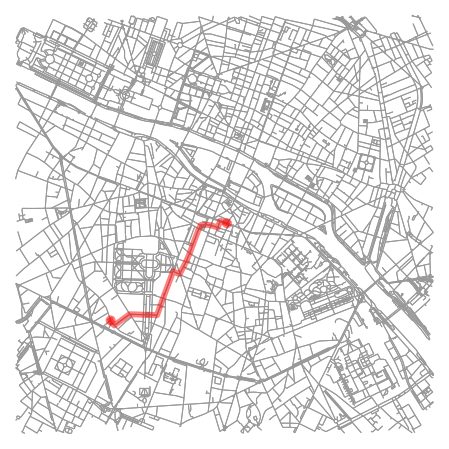

In [16]:
fig, ax = ox.plot_graph_route(streets_network, path, route_linewidth=6, node_size=0, bgcolor='w')

We can describe the shortest path using `osmnx`'s `bearing` attribute of the edges. `Bearing` represents the angle (in degrees) between the North and the geodesic line from the origin node to the destination node.

In [17]:
streets_network = ox.add_edge_bearings(streets_network) #Adding attribute to obtain direction of the edge

In [18]:
def compare_bearings(x,y):
    """x and y are angles measured in degrees from the north"""
    final_angle = y-x
    if 20.0 <= final_angle < 65.0:
        return("Slightly turn right to")
    elif 70.0 <= final_angle < 110.0:
        return("Turn right to")  
    elif -65.0 <= final_angle < -20:
        return("Slightly turn left to")
    elif -110.0 <= final_angle < -70.0:
        return("Turn left to") 
    elif -20.0 <= final_angle < 20.0:
        return("Move to") 
    else:
        return(str(final_angle))

The code below runs through every arcs of the shotest path and get its name, its length (which corresponds to the cost we minimized earlier), and its bearing.

When a street continues on a place, the name of the edge is a list of the name of the street and the name of the place in the second element. In this case we only keep the first element.

In [19]:
NamesAndDistances = []
for i in range(len(path)-1):
    length_total = 0
    newname = streets_network.edges[(path[i], path[i+1],0)]["name"]
    newdist = streets_network.edges[(path[i], path[i+1],0)]["length"] ##In meter
    newangle = streets_network.edges[(path[i], path[i+1],0)]["bearing"] ##In degrees 
    if isinstance(newname, list):
        NamesAndDistances.append([newname[0],newdist,newangle])
    else:
        NamesAndDistances.append([newname,newdist,newangle])
        
#NamesAndDistances

This list has duplicated names. The following `while loop` add the lengths of the edges with the same name. It also compares the bearing of the previous edge with a different name to the one into account. If the difference is negative, you will turn left, as stated in `compare_bearings`, otherwise you will turn right.

In [20]:
indications = []
set_names = set()
for i in range (len(NamesAndDistances)-1):
    if (NamesAndDistances[i][0] == NamesAndDistances[i+1][0]) and (NamesAndDistances[i][0] not in set_names):
        total_length = 0
        j=0
        while (NamesAndDistances[i+j][0] == NamesAndDistances[i][0]):
            total_length += NamesAndDistances[i+j][1]
            j +=1
            if i+j >len(NamesAndDistances)-1:
                break
        direction = compare_bearings(NamesAndDistances[i-1][2],NamesAndDistances[i][2])
        indications.append([direction,total_length,NamesAndDistances[i][0]])
        set_names.add(NamesAndDistances[i][0])
    elif NamesAndDistances[i][0] in set_names:
        pass
    else:
        direction = compare_bearings(NamesAndDistances[i-1][2],NamesAndDistances[i][2])
        indications.append([direction,NamesAndDistances[i][1],NamesAndDistances[i][0]])
        set_names.add(NamesAndDistances[i][0])

In [21]:
for x in indications:
    print(x[0],x[2], "for ", int(round(x[1],0)), "meters.") #round the distance at the nearest meter.

Slightly turn left to Boulevard Saint-Germain for  69 meters.
Turn left to Rue Thénard for  69 meters.
Turn right to Rue du Sommerard for  118 meters.
Move to Place Paul Painlevé for  89 meters.
Move to Place de la Sorbonne for  251 meters.
Move to Rue Victor Cousin for  87 meters.
Move to Rue Le Goff for  126 meters.
Turn right to Rue Royer-Collard for  72 meters.
Turn left to Boulevard Saint-Michel for  447 meters.
Turn right to Rue Michelet for  260 meters.
Slightly turn left to Rue Joseph Bara for  183 meters.
Turn right to Rue Notre-Dame-des-Champs for  60 meters.
